In [1]:
import os
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from datetime import datetime, date
import pacmap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import plotly.express as px
from kneed import KneeLocator
import distinctipy
import pickle

def compute_age(date_of_birth):
    if not date_of_birth:
        return None
    date_of_birth = datetime.strptime(date_of_birth, "%Y-%m-%d").date()
    today = date.today()
    # check if this year's birthday has passed:
    offset = int((today.month, today.day) < (date_of_birth.month, date_of_birth.day))

    return today.year - date_of_birth.year - offset
    
random_state = 42
np.random.seed(random_state)
colors = distinctipy.get_colors(5)

# Check and create figure directories
fig_dir = "figures"
if not os.path.exists(f"{fig_dir}/final_clustering"):
    os.mkdir(f"{fig_dir}/final_clustering")

# Load Data
clustering_df = pd.read_csv("../data/clustering_common_variables_la_fe.csv")
clustering_df = clustering_df.set_index(["protocol_id", "patient_id"])
metadata_df = pd.read_csv("../data/clustering_metadata_la_fe.csv", index_col=0)
metadata_df["age"] = metadata_df["birth_date"].apply(compute_age)
metadata_df.drop(["protocol_id", "protocol_name"], axis=1, inplace=True)
metadata_df.drop_duplicates(inplace=True)
metadata_df.set_index("patient_id", inplace=True)    
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 95 entries, ('LFE-0001-P0xzY-P-32tKi', '6gclT6rWzsXwLtFe0pec') to ('LFE-0001-P0xzY-P-VNg6R', 'vfsHLYsatEVLs2Ncp7Ne')
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   medication_compliance  95 non-null     float64
 1   hospitalization        95 non-null     float64
 2   death                  95 non-null     float64
 3   eat_well               95 non-null     float64
 4   is_vomiting            95 non-null     float64
 5   is_fatigued            95 non-null     float64
 6   has_high_fever         95 non-null     float64
 7   heart_rate             95 non-null     float64
 8   ER_contact             95 non-null     float64
 9   dyspnoea_scale         95 non-null     float64
 10  wellbeing_qual_-1      95 non-null     float64
 11  wellbeing_qual_0       95 non-null     float64
 12  wellbeing_qual_1       95 non-null     float64
 13  eat_quant_-1   

In [2]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 6gclT6rWzsXwLtFe0pec to vfsHLYsatEVLs2Ncp7Ne
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gender      90 non-null     object
 1   birth_date  90 non-null     object
 2   clinic_id   90 non-null     int64 
 3   age         90 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 3.5+ KB


In [3]:
# Drop dead patients
clustering_df.drop(clustering_df[clustering_df.death > 0].index, inplace=True)
clustering_df.drop(columns="death", axis=1, inplace=True)

In [5]:
# Standardize Data
var_list = list(clustering_df.columns)
X = clustering_df.to_numpy()
N, D = X.shape 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

/home/oscar/Desktop/Tucuvi/source/neotec/env/lib/python3.10/site-packages/pacmap/pacmap.py:774: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


Text(0.5, 1.0, 'GMM: PaCMAP Visualization')

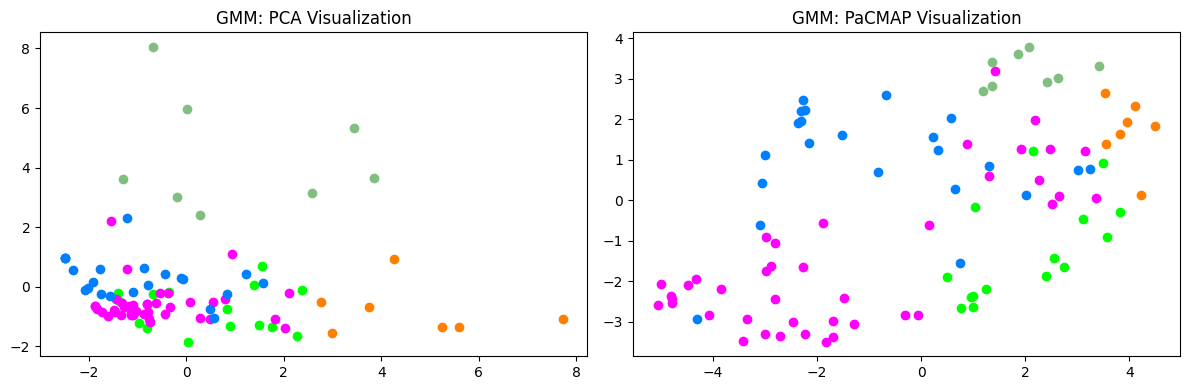

In [6]:
# Train Final GMM Model
n_components = 5
covariance_type = "full"
model = GMM(n_components=n_components, covariance_type=covariance_type)
labels = model.fit_predict(X_std)
centroids_norm = model.means_
centroid_df = pd.DataFrame(centroids_norm)
centroid_df.columns = clustering_df.columns
centroids = scaler.inverse_transform(centroids_norm)
cluster_id, cluster_count = np.unique(labels, return_counts=True)
clustering_df["cohort_label"] = labels

# PCA & PaCMAP
pca_trans = PCA(n_components=2,random_state=random_state)
X_norm_pca = pca_trans.fit_transform(X_std)

pacmap_trans = pacmap.PaCMAP(random_state=random_state)
X_norm_pacmap = pacmap_trans.fit_transform(X_std)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), tight_layout=True)
for l in np.unique(labels):
    ax1.scatter(
        X_norm_pca[labels == l, 0],
        X_norm_pca[labels == l, 1],
        color=colors[l])
for l in np.unique(labels):
    ax2.scatter(
        X_norm_pacmap[labels == l, 0],
        X_norm_pacmap[labels == l, 1],
        color=colors[l])
ax1.set_title("GMM: PCA Visualization")
ax2.set_title("GMM: PaCMAP Visualization")

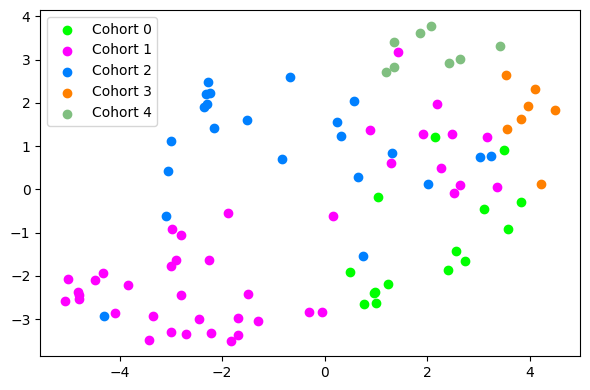

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for l in np.unique(labels):
    ax.scatter(
        X_norm_pacmap[labels == l, 0],
        X_norm_pacmap[labels == l, 1],
        color=colors[l],
        label=f"Cohort {l}")
ax.legend()
fig.savefig(f"{fig_dir}/final_clustering/pacmap.png")

In [8]:
# GMM Radar Plots
W = 5
for i in range(n_components):
    top_W_idx = np.argpartition(centroids_norm[i, :], -W)[-W:]
    top_W_vals = centroids_norm[i, top_W_idx]
    top_W_vars = [var_list[i] for i in top_W_idx]
    fig = px.line_polar(
        r=top_W_vals, 
        theta=top_W_vars,
        line_close=True,
        color_discrete_sequence=["green"])
    fig.update_traces(fill='toself')
    fig.update_polars(angularaxis_tickfont_size=30)
    fig.update_polars(radialaxis_tickfont_size=16)
    #fig.update_polars(gridshape="linear")
    #fig.show()
    fig.write_image(f"{fig_dir}/final_clustering/cohort_{cluster_id[i]}_weights.png", width=1000)